<a href="https://colab.research.google.com/github/KjelleJ/enkla-ai-experiment/blob/main/AIX_6_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Third Edition](https://www.manning.com/books/deep-learning-with-python-third-edition). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

The book's contents are available online at [deeplearningwithpython.io](https://deeplearningwithpython.io). **LÄS BOKEN SPECIELLT KAPITEL 1 SEN BLIR DET SVÅRARE**.

# Stable Diffusion
Stable Diffusion är en 'öppen' bildskapare som togs fram som en motvikt till t.ex. DALL-E. En diffusionsmodell kan skapa en bild ur brus men måste förstås tränas för att kunna det.


**Stable Diffusion** används genom att ge en prompt som beskriver önskad bild. För att det ska funka måste modellen tränas med många tusen bilder och motsvarande promptar. På så sätt byggs "Latent text/image space" upp - ett vektorrum.
Vid användning av modellen ger prompten en punkt i vektorrummet som ges som indata till decodern som skapar bilden med "omvänd diffusion".

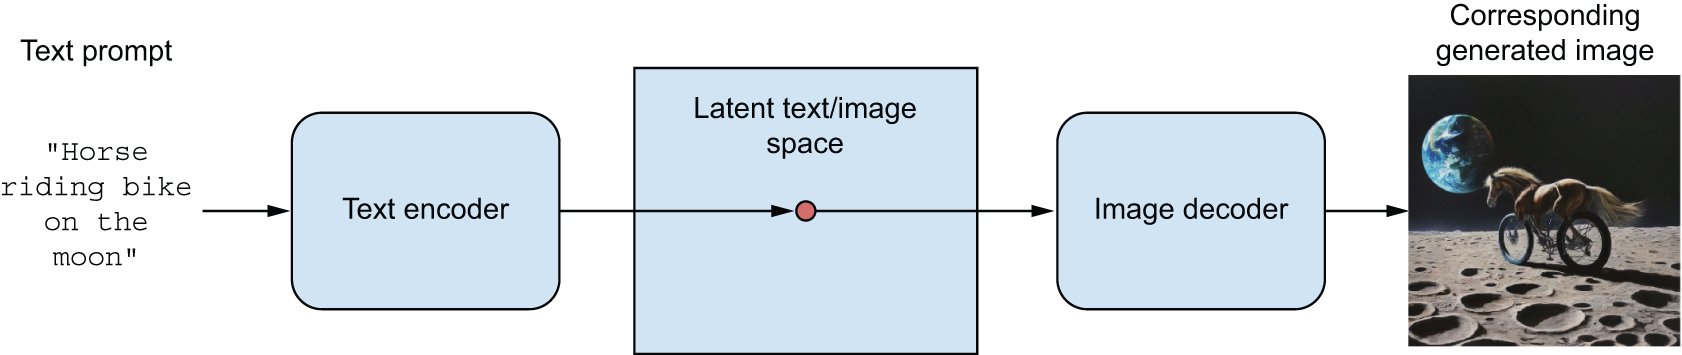

Träning av en enkel bildskapare.

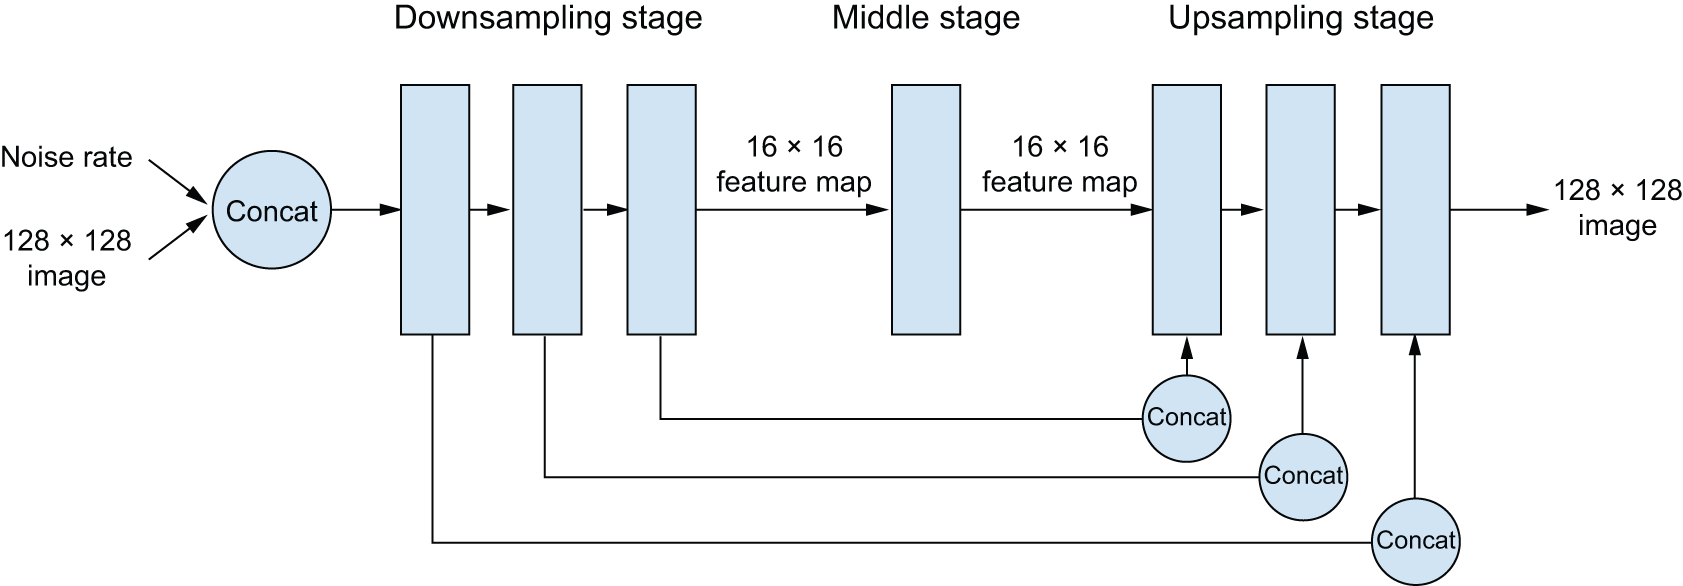

In [ ]:
!pip install keras-nlp --upgrade -q
!pip install keras keras-hub --upgrade -q

In [ ]:
import keras
import os
#os.environ["KERAS_BACKEND"] = "jax"
os.environ["KERAS_BACKEND"] = "torch"

In [ ]:
if keras.config.backend() == "torch":
    # The rest of this chapter will not do any training. The following keeps
    # PyTorch from using too much memory by disabling gradients. TensorFlow and
    # JAX use a much smaller memory footprint and do not need this hack.
    import torch

    torch.set_grad_enabled(False)

Vi använder en modell med 3 miljarder vikter. Den är alltså mycket stor men det är en liten Stable Diffusion-modell och kan ibland ha vissa brister...

In [ ]:
# Om vi inte sätter seed för generatorn får vi olika bilder för samma prompt
# Annars samma bild.
seed_value = 42

In [ ]:
# OBS! Kör bara den här cellen en gång. Annars kör du slut på GPU-minnet.
# Den här cellen tar ett par minuter...
import keras_hub

height, width = 512, 512
task = keras_hub.models.TextToImage.from_preset(
    "stable_diffusion_3_medium",
    image_shape=(height, width, 3),
    dtype="float16",
)

In [ ]:
prompt = "A NASA astraunaut riding an elephant in New York City"
task.generate(prompt, seed = seed_value)

In [ ]:
# Ska ge samma bild eftersom vi använder samma seed och samma prompt
task.generate(prompt, seed = seed_value)

In [ ]:
# En annan seed (eller ingen seed) ger en annan bild för samma prompt
task.generate(prompt, seed = 77)

In [ ]:
# En negativ prompt beskriver inte bilden men modifierar den.
task.generate(
    {
        "prompts": prompt,
        "negative_prompts": "blue color",
    },
    seed = seed_value)

In [ ]:
task.generate("A medival painting, flowers, a river and mountains")

In [ ]:
a

In [ ]:
task.generate("A surrealistic painting by Salavador Dali, a strange man and a strange clock in the desert")

---
# Visa den genererade bilden efter ett antal steg i diffusionsprocessen.
---

In [ ]:
# Visa den genererade bilden efter ett antal steg i diffusionsprocessen.
import numpy as np
from PIL import Image

def display(images):
    return Image.fromarray(np.concatenate(images, axis=1))

display([task.generate(prompt, num_steps=x, seed = seed_value) for x in [5, 10, 15, 20, 25]])

---
## Undersök den "latenta rymden" genom sfärisk interpolation
---




In [ ]:
from keras import random
from keras import ops

# we take our prompts, tokenize them, and embed them with our text encoder
def get_text_embeddings(prompt):
    token_ids = task.preprocessor.generate_preprocess([prompt])
    negative_token_ids = task.preprocessor.generate_preprocess([""])
    return task.backbone.encode_text_step(token_ids, negative_token_ids)

# we take our text embeddings and pure noise and
# progressively “denoise” the noise into an image
def denoise_with_text_embeddings(embeddings, num_steps=28, guidance_scale=7.0):
    latents = random.normal((1, height // 8, width // 8, 16))
    for step in range(num_steps):
        latents = task.backbone.denoise_step(
            latents,
            embeddings,
            step,
            num_steps,
            guidance_scale,
        )
    return task.backbone.decode_step(latents)[0]

# we map our model outputs, which are from [-1, 1] back to [0, 255]
# so we can render the image
def scale_output(x):
    x = ops.convert_to_numpy(x)
    x = np.clip((x + 1.0) / 2.0, 0.0, 1.0)
    return np.round(x * 255.0).astype("uint8")

embeddings = get_text_embeddings(prompt)
#image = denoise_with_text_embeddings(embeddings)
#scale_output(image)

In [ ]:
[x.shape for x in embeddings]

In [ ]:
from keras import ops

def slerp(t, v1, v2):
    v1, v2 = ops.cast(v1, "float32"), ops.cast(v2, "float32")
    v1_norm = ops.linalg.norm(ops.ravel(v1))
    v2_norm = ops.linalg.norm(ops.ravel(v2))
    dot = ops.sum(v1 * v2 / (v1_norm * v2_norm))
    theta_0 = ops.arccos(dot)
    sin_theta_0 = ops.sin(theta_0)
    theta_t = theta_0 * t
    sin_theta_t = ops.sin(theta_t)
    s0 = ops.sin(theta_0 - theta_t) / sin_theta_0
    s1 = sin_theta_t / sin_theta_0
    return s0 * v1 + s1 * v2

def interpolate_text_embeddings(e1, e2, start=0, stop=1, num=10):
    embeddings = []
    for t in np.linspace(start, stop, num):
        embeddings.append(
            (
                slerp(t, e1[0], e2[0]),
                e1[1],
                slerp(t, e1[2], e2[2]),
                e1[3],
            )
        )
    return embeddings

In [ ]:
# Vi skapar några bilder mellan punkterna motsvarande prompt1 och prompt2.
# Bilderna skapas efter mitten av avståndet mellan prompt1 och prompt2.
# Tar några minuter beroende på värdet av num (antal bilder)
prompt1 = "A friendly dog looking up in a field of flowers"
prompt2 = "A horrifying, tentacled creature hovering over a field of flowers"
e1 = get_text_embeddings(prompt1)
e2 = get_text_embeddings(prompt2)

images = [] # This will store all generated numpy arrays
for et in interpolate_text_embeddings(e1, e2, start=0.5, stop=0.6, num=9):
#for et in interpolate_text_embeddings(e1, e2, start=0., stop=1., num=9):
    image = denoise_with_text_embeddings(et)
    images.append(scale_output(image))
display(images)